<a href="https://colab.research.google.com/github/xbadiam/Forecasting_weather_with_LSTM/blob/main/notebooks/Forecasting_univariate_unistep_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Contexto

### 1.1 Modelos univariados-unistep

El modelo univariado-unistep es el tipo de predicción más simple que podemos realizar usando Redes LSTM.

En este tipo de configuración usamos una variable a la entrada del modelo y tendremos una variable de salida y la predicción se realiza tan sólo un instante de tiempo a futuro dentro de la serie. Además, generalmente la variable de entrada es la misma variable a predecir.

Por ejemplo, si volvemos al caso de la temperatura, podríamos desarrollar un modelo que acepte un registro histórico de 24 horas de la temperatura y que aprenda a predecir el comportamiento que tendrá esa misma variable temperatura en la siguiente hora.

In [16]:
!rm -rf /content/Forecasting_weather_with_LSTM

! git clone https://github.com/xbadiam/Forecasting_weather_with_LSTM.git

Cloning into 'Forecasting_weather_with_LSTM'...
remote: Enumerating objects: 66, done.
remote: Counting objects: 100% (66/66), done.
remote: Compressing objects: 100% (62/62), done.
remote: Total 66 (delta 21), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (66/66), 2.68 MiB | 4.09 MiB/s, done.
Resolving deltas: 100% (21/21), done.


In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Modelado y Forecasting
# ==============================================================================
import tensorflow as tf
import keras
from keras import layers
from keras import ops
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import LSTM, Dense
#from tensorflow.keras.optimizers import RMSprop

In [46]:
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.19.0


## 2. Funciones especiales

In [37]:
# Función para generar las particiones preservando las características
# de la serie de tiempo

def train_val_test_split(serie, tr_size=0.8, vl_size=0.1, ts_size=0.1 ):
    # Definir número de datos en cada subserie
    data_number = serie.shape[0]
    n_train = int(tr_size* data_number)  # Número de datos de entrenamiento
    n_val = int(vl_size* data_number)    # Número de datos de validación
    n_test = data_number - n_train - n_val # Número de datos de prueba

    # Realizar partición
    train = serie[0:n_train]
    val = serie[n_train:n_train + n_val]
    test = serie[n_train + n_val:]

    return train, val, test

def create_dataset_supervised(array, input_length, output_length):
  '''Permite crear un dataset con las entradas (X) y salidas (Y)
  requeridas por la Red LSTM.

  Parámetros:
    - array: numpy de tamaño N x features (N: cantidad de datos,
      f: cantidad de features).
    - input_length: instantes de tiempo consecutivos de la(s) serie(s) de tiempo
      usados para alimentar el modelo.
    - output_length: instantes de tiempo a pronosticar (salida del modelo)
  '''

  # Inicialización
  X, Y = [], []    # Listados con los datos de entrada y salida del modelo
  shape = array.shape
  if len(shape) ==1: # Si tenemos sólo una serie (univariado)
    fils, cols = array.shape[0], 1
    array = array.reshape(fils, cols)
  else: # Multivariado
     fils, cols = array.shape

  # Generar los arreglos
  for i in range(fils - input_length - output_length):
    X.append(array[i:i + input_length, 0:cols])
    Y.append(array[i + input_length:i + input_length + output_length, -1].reshape(output_length, 1))

  # Convertir listas a arreglos de NumPy
  X = np.array(X)
  Y = np.array(Y)

  return X, Y


def escalar_dataset(data_input):
  '''Escala el dataset en el rango de -1 a 1.
  Entradas:
    data_input: diccionario con los dataset de entrada y salida del modelo
    (data_input = {'x_train':x_train, 'y_train':y_train,
                   'x_val':x_val, 'y_val':y_val,
                    'y_test':y_test})

  Retorna:
    - data_scaled: diccionario con los datasets de entrada y salida escalados
      (tiene la misma estructura del diccionario de entrada)
    - scaler: el escalador usado (requerido para las predicciones)
    '''

  NFEATS = data_input['x_train'].shape[2]

  # Generar listado con "scalers" (en este caso, por ser sólo 1 característica
  # se tendrá sólo 1 escalador)
  scalers = [MinMaxScaler(feature_range=(-1,1)) for i in range(NFEATS)]

  # Arreglos que contendrán los datasets escalados
  x_train_scaled = np.zeros(data_input['x_train'].shape)
  x_val_scaled = np.zeros(data_input['x_val'].shape)
  x_test_scaled = np.zeros(data_input['x_test'].shape)
  y_train_scaled = np.zeros(data_input['y_train'].shape)
  y_val_scaled = np.zeros(data_input['y_val'].shape)
  y_test_scaled = np.zeros(data_input['y_test'].shape)

  # Escalamiento: se usarán los min/max del set de entrenamiento para
  # escalar la totalidad de los datasets

  # Escalamiento Xs: en este caso debemos garantizar que cada dato de entrada
  # a fit_transform o transform debe ser de tamaño nsamples x nfeatures
  # (en este caso 24x13)
  for i in range(NFEATS):
    x_train_scaled[:,:,i] = scalers[i].fit_transform(x_train[:,:,i])
    x_val_scaled[:,:,i] = scalers[i].transform(x_val[:,:,i])
    x_test_scaled[:,:,i] = scalers[i].transform(x_test[:,:,i])

  # Escalamiento Ys
  y_train_scaled[:,:,0] = scalers[-1].fit_transform(y_train[:, :,0])
  y_val_scaled[:,:,0] = scalers[-1].transform(y_val[:, :,0])
  y_test_scaled[:,:,0] = scalers[-1].transform(y_test[:, :,0])

  # Conformar diccionario de salida
  data_scaled = {
      'x_train_scaled': x_train_scaled, 'y_train_scaled': y_train_scaled,
      'x_val_scaled': x_val_scaled, 'y_val_scaled': y_val_scaled,
      'x_test_scaled': x_test_scaled, 'y_test_scaled': y_test_scaled,
  }

  return data_scaled, scalers[0]

## 3. Cargar datos

In [19]:
data = pd.read_csv('/content/Forecasting_weather_with_LSTM/outputs/weather_dataset_preprocesado.csv')
data.head(5)

,date,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,2009-01-01 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
1,2009-01-01 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
2,2009-01-01 03:00:00,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
3,2009-01-01 04:00:00,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
4,2009-01-01 05:00:00,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


In [20]:
data.shape

(50224, 15)

## 4. Partición del dataset

In [21]:
train, val, test = train_val_test_split(data['T (degC)'])

print(f'Tamaño set de entrenamiento: {train.shape}')
print(f'Tamaño set de validación: {val.shape}')
print(f'Tamaño set de prueba: {test.shape}')

Tamaño set de entrenamiento: (40179,)
Tamaño set de validación: (5022,)
Tamaño set de prueba: (5023,)


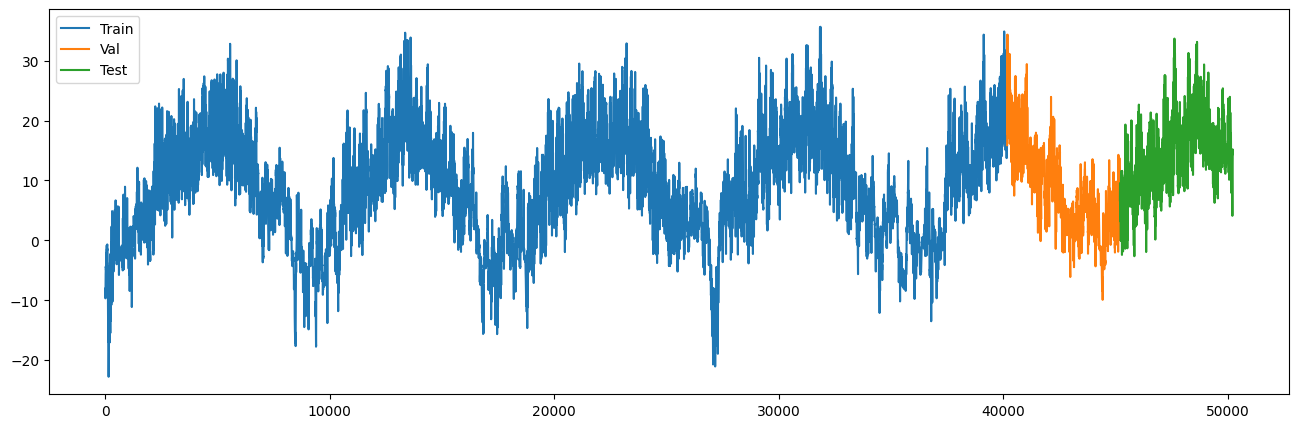

In [22]:
# Dibujemos los subsets
fig, ax = plt.subplots(figsize = (16,5))
ax.plot(train, label='Train')
ax.plot(val, label='Val')
ax.plot(test, label='Test')
plt.legend();

Observemos que por ser un modelo univariado sólo estamos preservando la variable temperatura (y que incluso hemos eliminado la información de fecha y hora de cada registro).

### 4.1 Generación del dataset supervisado (entrada y salida del modelo)

Debemos ajustar nuestro set de datos de acuerdo a lo especificado en la [documentación de las Redes LSTM en TensorFlow/Keras](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM):

![](https://drive.google.com/uc?export=view&id=14Sb7zIdjurirW-C6-DWDTvpxOVafTnTK)


Donde:

1. Entrada

* **Batches**:Los lotes contienen el número total de datos de entrenamiento.
* **Input_lenght**: es el número de horas consecutivas que vamos a representar en la entrada del modelo.
* **Features**: son las características de entrada.

2. Salida se conforma un vector formado por

* **Batches**: Los lotes o bloques que se ha partido los datos de entrenamiento  entrenamientos formados por el número de predicciones
* **Input_lenght**: El número de horas a predecir en un futuro.
* **Features**: Características de salida.

Así que en este caso cada dato de entrenamiento será:

- Un arreglo de 24 (horas) x 1 (feature) correspondiente a la entrada
- Un arreglo de 1 (hora) x 1 (feature) correspondiente a la hora 25 (a predecir):

![](https://drive.google.com/uc?export=view&id=1uJeqYz9Hm2Q3LmEpXhZHogOI_rhj7YC2)

Crearemos una función que podremos reutilizar más adelante para implementar modelos más complejos:

In [24]:
# Crear los datasets de entrenamiento, prueba y validación y verificar sus tamaños
INPUT_LENGTH = 24    # Posteriormente afinaremos este hiperparámetro
OUTPUT_LENGTH = 1    # Modelo uni-step

x_train, y_train = create_dataset_supervised(train.values, INPUT_LENGTH, OUTPUT_LENGTH)
x_val, y_val = create_dataset_supervised(val.values, INPUT_LENGTH, OUTPUT_LENGTH)
x_test, y_test = create_dataset_supervised(test.values, INPUT_LENGTH, OUTPUT_LENGTH)

# Imprimir información en pantalla
print('Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)')
print(f'Set de entrenamiento - x_train: {x_train.shape}, y_tr: {y_train.shape}')
print(f'Set de validación - x_val: {x_val.shape}, y_vl: {y_val.shape}')
print(f'Set de prueba - x_test: {x_test.shape}, y_ts: {y_test.shape}')

Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)
Set de entrenamiento - x_tr: (40154, 24, 1), y_tr: (40154, 1, 1)
Set de validación - x_vl: (4997, 24, 1), y_vl: (4997, 1, 1)
Set de prueba - x_ts: (4998, 24, 1), y_ts: (4998, 1, 1)


## 5. Escalado de los datos

Es requerido para garantizar que todas las características se encuentran en el mismo rango de valores, lo que facilita el entrenamiento del modelo y las predicciones:

In [39]:
# Crear diccionario de entrada
data_in = {
    'x_train': x_train, 'y_train': y_train,
    'x_val': x_val, 'y_val': y_val,
    'x_test': x_test, 'y_test': y_test
}

In [40]:
# Y escalar
data_scaled, scaler = escalar_dataset(data_in)

In [41]:
# Extraer subsets escalados
x_train_scaled, y_train_scaled = data_scaled['x_train_scaled'], data_scaled['y_train_scaled']
x_val_scaled, y_val_scaled = data_scaled['x_val_scaled'], data_scaled['y_val_scaled']
x_test_scaled, y_test_scaled = data_scaled['x_test_scaled'], data_scaled['y_test_scaled']

In [42]:
# Verificación
print(f'Min x_train/x_val/x_test sin escalamiento: {x_train.min()}/{x_val.min()}/{x_test.min()}')
print(f'Min x_train/x_val/x_test con escalamiento: {x_train_scaled.min()}/{x_val_scaled.min()}/{x_test_scaled.min()}')

print(f'\nMin y_train/y_val/y_test sin escalamiento: {y_train.min()}/{y_val.min()}/{y_test.min()}')
print(f'Min y_train/y_val/y_test con escalamiento: {y_train_scaled.min()}/{y_val_scaled.min()}/{y_test_scaled.min()}')

print(f'\nMax x_train/x_val/x_test sin escalamiento: {x_train.max()}/{x_val.max()}/{x_test.max()}')
print(f'Max x_train/x_val/x_test con escalamiento: {x_train_scaled.max()}/{x_val_scaled.max()}/{x_test_scaled.max()}')

print(f'\nMax y_train/y_val/y_test sin escalamiento: {y_train.max()}/{y_val.max()}/{y_test.max()}')
print(f'Max y_train/y_val/y_test con escalamiento: {y_train_scaled.max()}/{y_val_scaled.max()}/{y_test_scaled.max()}')


Min x_train/x_val/x_test sin escalamiento: -22.76/-9.92/-2.64
Min x_train/x_val/x_test con escalamiento: -1.0/-0.5603492552645094/-0.31107687039890414

Min y_train/y_val/y_test sin escalamiento: -22.76/-9.92/-2.64
Min y_train/y_val/y_test con escalamiento: -1.0/-0.5603492552645094/-0.31107687039890414

Max x_train/x_val/x_test sin escalamiento: 35.65/34.34/33.68
Max x_train/x_val/x_test con escalamiento: 1.0000000000000002/0.9551446670090742/0.932545796952577

Max y_train/y_val/y_test sin escalamiento: 35.65/31.33/33.68
Max y_train/y_val/y_test con escalamiento: 1.0000000000000002/0.8520801232665642/0.932545796952577


## 6. Modelado

- Entradas: arreglos *x* (batches x input-length  x features = batches x 24 x 1)
- Salidas: arreglos *y* (batches x output-length x features = batches x 1 x 1)

Usaremos la raíz cuadrada del error cuadrático medio (o RMSE por sus siglas en Inglés: *root mean square error*) como pérdida para entrenar el modelo:

$RMSE = \sqrt{\frac{\sum_i (y_i-\hat{y_i})^2}{N}}$

donde:
- $y$: temperatura real
- $\hat{y}$: temperatura predicha
- $N$: cantidad de predicciones

In [49]:
# Ajustar parámetros para reproducibilidad del entrenamiento
tf.random.set_seed(123)
tf.config.experimental.enable_op_determinism()

# El modelo
N_UNITS = 128 # Tamaño del estado oculto (h) y de la celda de memoria (c)
INPUT_SHAPE = (x_train_scaled.shape[1], x_train_scaled.shape[2]) # 24 (horas) x 1 (feature)


In [52]:
modelo = keras.Sequential()
modelo.add(layers.LSTM(N_UNITS, input_shape=(INPUT_SHAPE)))
modelo.add(layers.Dense(OUTPUT_LENGTH, activation='linear')) # activation = 'linear' pues queremos pronosticar (regresión)

In [53]:
# Pérdida: se usará el RMSE (root mean squared error) para el entrenamiento
# pues permite tener errores en las mismas unidades de la temperatura
def root_mean_squared_error(y_true, y_pred):
    rmse = tf.math.sqrt(tf.math.reduce_mean(tf.square(y_pred - y_true)))
    return rmse

In [55]:
# Compilación
optimizador = tf.keras.optimizers.RMSprop(learning_rate = 5e-5)
modelo.compile(
    optimizer = optimizador,
    loss = root_mean_squared_error,
)

# Entrenamiento (aproximadamente 1 min usando GPU)
EPOCHS = 80 # Hiperparámetro
BATCH_SIZE = 256 # Hiperparámetro
historia = modelo.fit(
    x = x_train_scaled,
    y = y_train_scaled,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_data = (x_val_scaled, y_val_scaled),
    verbose=2
)

Epoch 1/80
157/157 - 17s - 107ms/step - loss: 0.1904 - val_loss: 0.0992
Epoch 2/80
157/157 - 15s - 97ms/step - loss: 0.1165 - val_loss: 0.0900
Epoch 3/80
157/157 - 16s - 103ms/step - loss: 0.1050 - val_loss: 0.0814
Epoch 4/80
157/157 - 15s - 96ms/step - loss: 0.0925 - val_loss: 0.0717
Epoch 5/80
157/157 - 15s - 97ms/step - loss: 0.0765 - val_loss: 0.0602
Epoch 6/80
157/157 - 15s - 95ms/step - loss: 0.0624 - val_loss: 0.0542
Epoch 7/80
157/157 - 21s - 132ms/step - loss: 0.0577 - val_loss: 0.0516
Epoch 8/80
157/157 - 21s - 134ms/step - loss: 0.0549 - val_loss: 0.0494
Epoch 9/80
157/157 - 21s - 132ms/step - loss: 0.0524 - val_loss: 0.0474
Epoch 10/80
157/157 - 15s - 98ms/step - loss: 0.0502 - val_loss: 0.0455
Epoch 11/80
157/157 - 16s - 105ms/step - loss: 0.0483 - val_loss: 0.0439
Epoch 12/80
157/157 - 16s - 100ms/step - loss: 0.0466 - val_loss: 0.0425
Epoch 13/80
157/157 - 21s - 131ms/step - loss: 0.0451 - val_loss: 0.0412
Epoch 14/80
157/157 - 15s - 98ms/step - loss: 0.0438 - val_loss: 

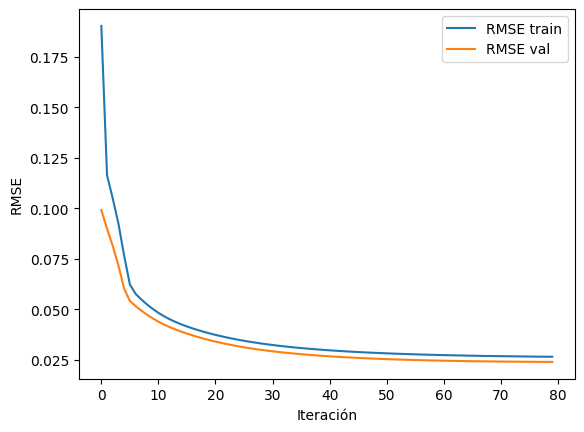

In [56]:
# Graficar curvas de entrenamiento y validación
 # para verificar que no existe overfitting
plt.plot(historia.history['loss'], label='RMSE train')
plt.plot(historia.history['val_loss'], label='RMSE val')
plt.xlabel('Iteración')
plt.ylabel('RMSE')
plt.legend();